In [1]:
import numpy as np
import pandas as pd
import fiona
import geopandas as gpd
from shapely import geometry, ops
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import cm
from pysheds.grid import Grid
from matplotlib import colors
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set()
sns.set_palette('husl', 8)

%matplotlib inline

In [2]:
grid = Grid.from_raster('../data/n30w100_dir', data_name='dir')

In [3]:
dirmap = (64,  128,  1,   2,    4,   8,    16,  32)

# Specify pour point
x, y = -97.294167, 32.73750

# Delineate the catchment
grid.catchment(data='dir', x=x, y=y, dirmap=dirmap, out_name='catch',
               recursionlimit=15000, xytype='label')

# Clip the bounding box to the catchment
grid.clip_to('catch', pad=(1,1,1,1))

# Compute flow distance
grid.flow_distance(data='catch', x=x, y=y, dirmap=dirmap, out_name='dist', xytype='label')
dist = grid.view('dist', nodata=0, dtype=np.float64)

In [4]:
grid.accumulation(data='catch', dirmap=dirmap)

In [5]:
p = grid.polygonize()

In [6]:
p = ops.unary_union([geometry.shape(i) for i, j in p])

In [7]:
f = gpd.GeoDataFrame.from_file('/home/mdbartos/Data/GIS/NHDPlus_H_1203/NHDPlus_H_1203_GDB.gdb/',
                               layer='NHDFlowline')

In [8]:
f = f[f.geometry.intersects(p)]
f.geometry = f.geometry.intersection(p)

Text(0.5,1,'Cells with >100 accumulation')

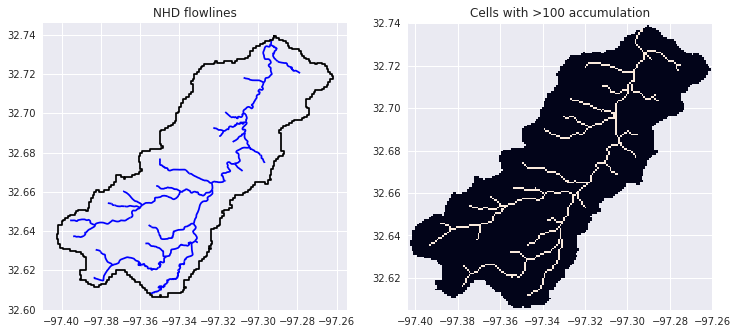

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].set_aspect('equal')
f.plot(ax=ax[0], color='b')
xs, ys = p.exterior.xy
ax[0].plot(xs, ys, c='k')

ax[1].imshow(np.where(grid.mask, grid.view('acc') > 100, np.nan),
             zorder=1, extent=grid.extent)
ax[0].set_title('NHD flowlines')
ax[1].set_title('Cells with >100 accumulation')